# Сборный проект

**Цель исследования:**
1. Найти закономерности, определяющие успешность игры.
<br>
2. Проверить гипотезы:
<ul>
<li>Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;</li>
<li>Средние пользовательские рейтинги жанров Action и Sports разные.</li>
<ul>
**Ход исследования:**
 1. Обзор данных.
 2. Предобработка данных.
 3. Анализ данных.
 4. Проверка гипотез.

### Изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**В данных есть пропущенные значения, в названиях столбцов используются верхний регистр.**

### Предобработка данных

In [4]:
data.duplicated().sum() #Проверка на явные дубликаты

0

In [5]:
#Приводим названия столбцов к нижнему регистру
data = data.rename(columns = {'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release', 'Genre':'genre', 'NA_sales':'na_sales', 'EU_sales':'eu_sales', 'JP_sales':'jp_sales', 'Other_sales':'other_sales', 'Critic_Score':'critic_score', 'User_Score':'user_score', 'Rating':'rating'})

In [6]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

**В данных есть пропуски, избавимся от них там, где это возможно.**

**Есть по два пропуска в столбцах в названиями и жанрами, удалим их.**

In [7]:
data.loc[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
data = data.loc[~data['name'].isna()]

**Также удалим строки, в которых отсутствует год релиза игры, т.к. таких строк не так много.**

In [9]:
data = data.loc[~data['year_of_release'].isna()]

**Заменим пропуски в категориальном столбце "rating" на "unknown".**

In [10]:
data.loc[data['rating'].isna(), 'rating'] = 'unknown' 

**Пропуски в столбцах "user_score" и "critic_score" заполнять не будем, т.к. это может сильно исказить результаты анализа.**

**Изменим тип данных столбца "year_of_release" на целочисленный, т.к. год указывается только целым числом.**

In [11]:
data['year_of_release'] = data['year_of_release'].astype('int')

**Заменим значения "tbd" в столбце "user_score" на пропуски, далее заменим тип столбца на нецелочисленный.**

In [12]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')

In [13]:
data['user_score'] = data['user_score'].astype('float')

**Создадим столбец "total_sales" и запишем в него сумму продаж всех регионов.**

In [14]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

**В данных были обнаружены пропуски, от некоторых мы избавились, но пропуски в столбцах с оценками пользователей и критиков заполнить не удалось, т.к. их заполнение может некорректно сказаться за итоговых результатах, часть столбцов была преведена к другому типу данных, также были изменены названия столбцов в соответствии с «хорошим стилем».** 

### Анализ данных

**Посмотрим на количество выпущенных игр в каждый год.**

In [15]:
data['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

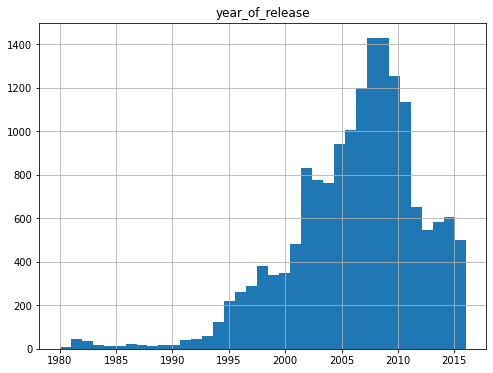

In [16]:
data.hist('year_of_release', bins = len(data['year_of_release'].unique()), figsize=(8,6));

**До 1993 года количество выпускаемых в год игр было менее 100, начиная с 1994 года количество игр начало стремительно расти, в период 2006-2011 год количество выпускаемых игр превышало 1000 за каждый год, после 2011 года число выпускаемых игр резко упало.** 

In [17]:
top_platforms = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(6)

In [18]:
top_platforms_by_years = data.query('platform in @top_platforms.index').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

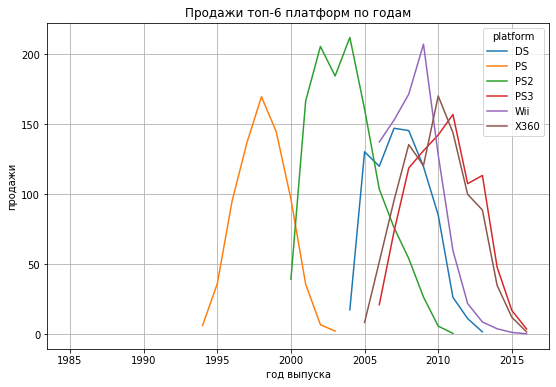

In [19]:
top_platforms_by_years.plot(xlabel = 'год выпуска', ylabel = 'продажи', figsize = (9,6), grid = True, title = 'Продажи топ-6 платформ по годам');

**Определим актуальный прериод, для этого возьмеем среднее количество продаж для всех топ шести компаний, далее выберем те года, когда продажи каждой платформы были выше средней и найдем среднее этих лет.**

In [20]:
top_platforms_by_years.mean().mean()

82.38693939393943

In [21]:
(len(top_platforms_by_years.query('PS2>83')) + len(top_platforms_by_years.query('X360>83')) + len(top_platforms_by_years.query('PS3>83')) + len(top_platforms_by_years.query('Wii>83')) + len(top_platforms_by_years.query('DS>83')) + len(top_platforms_by_years.query('PS>83'))) / 6

5.833333333333333

**Получаем почти шесть лет, но возьмем актуальный период 5 лет, т.к. во многие годы у платформ были низкие продажи, что повлияло на среднее значение(медиану не было смысла брать, т.к. небольшое количество лет).**

In [22]:
#Создаем датафрейм с играми, выпущенными после 2011 года
data_actual = data.query('year_of_release>2011')

In [23]:
actual_pivot = data_actual.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

In [24]:
#Смотрим на продажи платформ за актуальный период
actual_pivot.sum().sort_values(ascending=False)

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
dtype: float64

**В топ-5 лидирующих по продажам платформ входят PS4, PS3, X360, 3DS, XOne.**   

In [25]:
actual_pivot

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


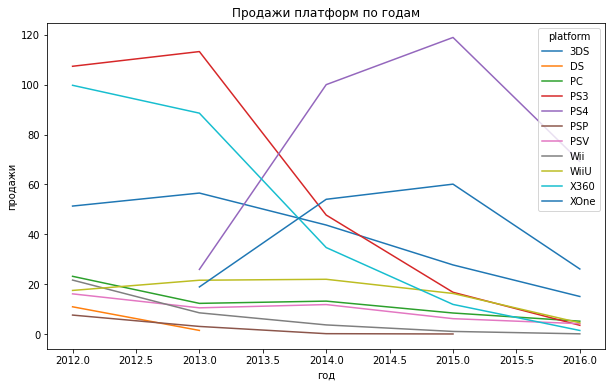

In [26]:
actual_pivot.plot(xlabel = 'год', ylabel = 'продажи', title = 'Продажи платформ по годам', figsize=(10,6));

**Все платформы в 2016 году сделали меньше продаж, по сравнению с 2015 годом, многие платформы начали падать еще до этого, исключением являются PS4 и XOne, они росли вплоть до 2015 года. Эти платформы в 2017 потенциально могут показать результаты лучше, чем в 2016, т.к. только они показывали рост продаж в каждый год, кроме 2016(падение в 2016 году продаж у всех платформ может быть связано с уменьшением количества выпущенных игр или с каким-либо другим фактором).**

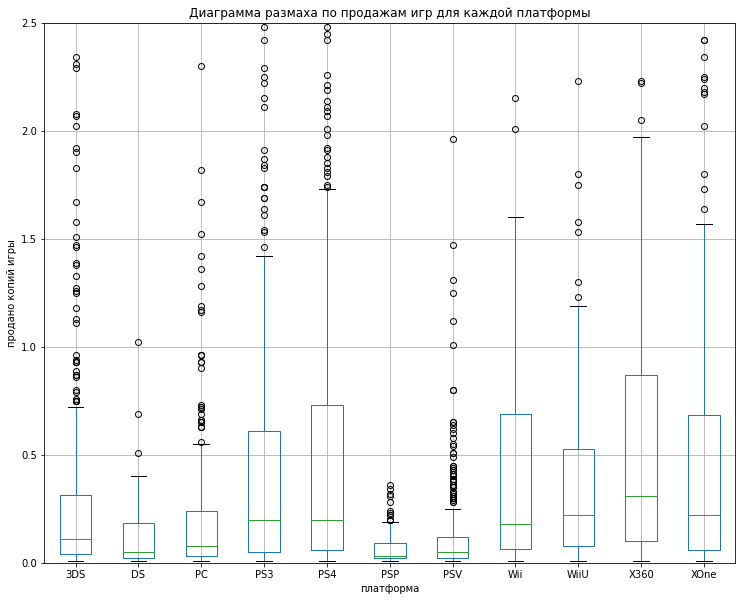

In [27]:
data_actual.boxplot('total_sales', by='platform', figsize=(12,10))
plt.suptitle('')
plt.title('Диаграмма размаха по продажам игр для каждой платформы')
plt.xlabel('платформа')
plt.ylabel('продано копий игры')
plt.ylim(0,2.5);

**У большинства платформ медиана продаж находится ниже 0,25 миллионов, лишь у X360 медиана превышает это значение, также у этой платформы наибольший порог выбросов(около 1,9 миллионов продаж), далее идет PS4, у этой платформы выбросами являются игры, продажи которых превышают 1,75 миллиона копий, рядом стоят Wii и XOne, у них выбросы начинаются примерно с 1,6 миллиона.**

**Посмотрим на влияние отзывов критиков и покупателей на продажи внутри платформы PS4.**

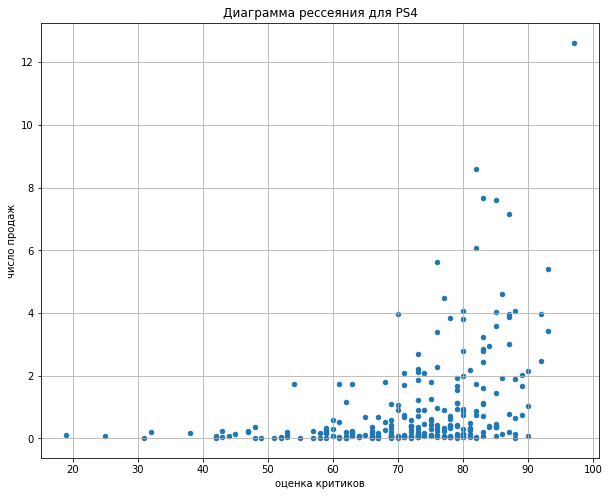

In [28]:
data_actual.query('platform=="PS4"').plot(x='critic_score', y='total_sales', kind='scatter', figsize=(10,8), grid = True, xlabel='оценка критиков', ylabel='число продаж', title='Диаграмма рессеяния для PS4');

**Игры, которые купили 2 и более миллиона раз, имеют выскоие оценки от критиков, свыше 70 баллов, но также есть множество игр, у которых мало продаж и которые имеют высокие оценки, а вот игр, которые имеют много продаж и невысокие оценки практически нет, т.е. зависимость прослеживается, но не всегда.** 

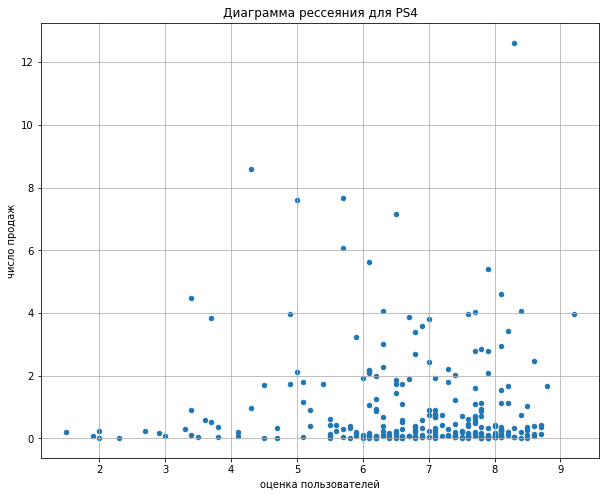

In [29]:
data_actual.query('platform=="PS4"').plot(x='user_score', y='total_sales', kind='scatter', figsize=(10,8), grid = True, xlabel='оценка пользователей', ylabel='число продаж', title='Диаграмма рессеяния для PS4');

**С оценками пользователей картина немного иная, есть много игр с большим количеством продаж и невысокими или средними оценками, также много игр с высокими оценками и низким количеством продаж.**

In [30]:
#Посмотрим корреляцию продаж и оценок критиков
data_actual.query('platform=="PS4"')['critic_score'].corr(data_actual.query('platform=="PS4"')['total_sales'])

0.40656790206178095

**В подтверждение к графику корреляция указывает на наличие зависимости, но небольшой.**

In [31]:
#Корреляция продаж и оценок пользователей 
data_actual.query('platform=="PS4"')['user_score'].corr(data_actual.query('platform=="PS4"')['total_sales'])

-0.031957110204556376

**Корреляция около нулевая, это указывает на то, что зависимости между продажами игр и оценками пользователей практически нет.**

**Сравним результаты с другими платформами из топ-3 по продажам.**

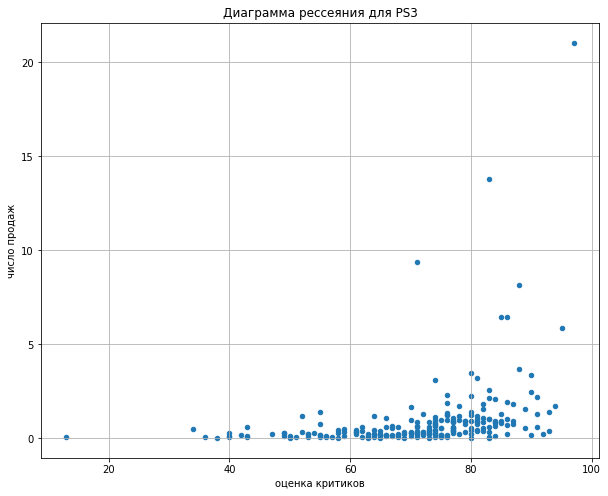

In [32]:
#Диаграмма рассеяния продаж и оценок критиков для PS3
data_actual.query('platform=="PS3"').plot(x='critic_score', y='total_sales', kind='scatter', figsize=(10,8), grid = True, xlabel='оценка критиков', ylabel='число продаж', title='Диаграмма рессеяния для PS3');

**Практически такая же картина, как и у PS4, все игры, имеющие свыше 2,5 миллионов продаж имеют высокие оценки критиков, нет игр с низкими оценками и высокими продажами, но есть много игр с низкими продажами и высокими оценками.**

In [33]:
data_actual.query('platform=="PS3"')['critic_score'].corr(data_actual.query('platform=="PS3"')['total_sales'])

0.3314972592629587

**Корреляция 0,33 также говорит о наличии небольшой зависимости.**

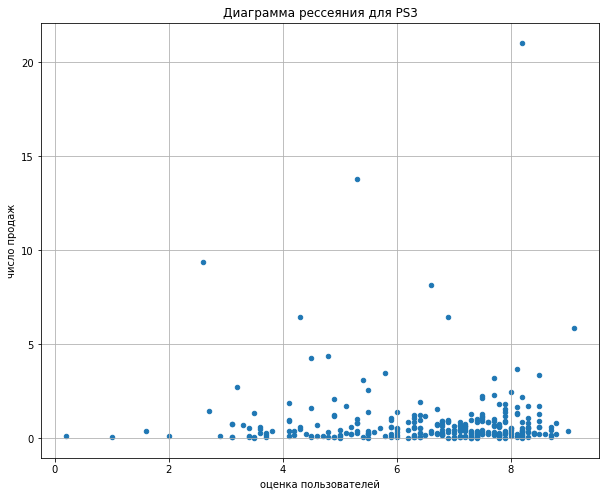

In [34]:
#Диаграмма рассеяния продаж и оценок пользователей для PS3
data_actual.query('platform=="PS3"').plot(x='user_score', y='total_sales', kind='scatter', figsize=(10,8), grid = True, xlabel='оценка пользователей', ylabel='число продаж', title='Диаграмма рессеяния для PS3');

**Здесь диаграмма также схожа с диаграммой для PS4, игры с достаточно высокими продажами имеют как высокие, так и средние и низкие оценки, много игр с высокими оценками и низкими продажами.**

In [35]:
data_actual.query('platform=="PS3"')['user_score'].corr(data_actual.query('platform=="PS3"')['total_sales'])

-0.005143522887113828

**Также практически нулевая корреляция, сведетельствующая об отсутствии зависимостм между продажами и оценками пользователей.**

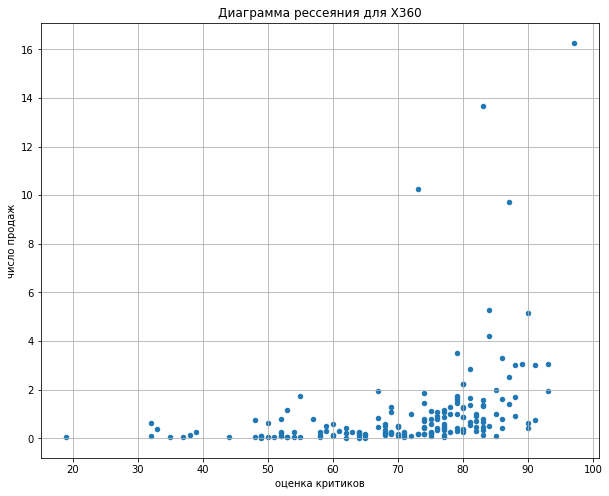

In [36]:
#Диаграмма рассеяния продаж и оценок критиков для X360
data_actual.query('platform=="X360"').plot(x='critic_score', y='total_sales', kind='scatter', figsize=(10,8), grid = True, xlabel='оценка критиков', ylabel='число продаж', title='Диаграмма рессеяния для X360');

**У X360 идентичная картина для диаграммы рассеяния продаж и оценок критиков.**

In [37]:
data_actual.query('platform=="X360"')['critic_score'].corr(data_actual.query('platform=="X360"')['total_sales'])

0.3605734888507336

**Корреляция 0.36 также гооврит о небольшой зависимости.**

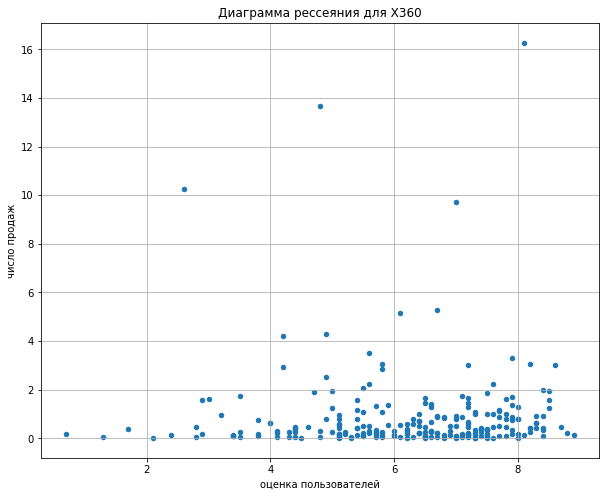

In [38]:
#Диаграмма рассеяния продаж и оценок пользователей для X360
data_actual.query('platform=="X360"').plot(x='user_score', y='total_sales', kind='scatter', figsize=(10,8), grid = True, xlabel='оценка пользователей', ylabel='число продаж', title='Диаграмма рессеяния для X360');

**С диаграммой для оценок пользователей и продаж у X360 все схоже с PS3 и PS4.**

In [39]:
data_actual.query('platform=="X360"')['user_score'].corr(data_actual.query('platform=="X360"')['total_sales'])

0.006163978646213326

**Здесь также корреляция близка к нулю.**

**Посчитаем корреляции у других платформ.**

In [40]:
warnings.filterwarnings('ignore')
for platform in actual_pivot.sum().sort_values(ascending=False).tail(8).index:
    print('Корреляция между оценками критиков и продажами для', platform, 'равна', data_actual.query('platform==@platform')['critic_score'].corr(data_actual.query('platform==@platform')['total_sales']))

Корреляция между оценками критиков и продажами для 3DS равна 0.3208028695360785
Корреляция между оценками критиков и продажами для XOne равна 0.4169983280084017
Корреляция между оценками критиков и продажами для WiiU равна 0.34837976012017485
Корреляция между оценками критиков и продажами для PC равна 0.23724324311567915
Корреляция между оценками критиков и продажами для PSV равна 0.0944878992931617
Корреляция между оценками критиков и продажами для Wii равна -0.4243413011077494
Корреляция между оценками критиков и продажами для DS равна nan
Корреляция между оценками критиков и продажами для PSP равна nan


**Среди таких платформ, как 3DS, XOne, WiiU, PC также прослеживается небольшая зависимость между оценками критиков и числом продаж, у платформ Wii, DS, PSP недостаточно данных, лишь у платформы PSV практически нет зависимости.**

In [41]:
for platform in actual_pivot.sum().sort_values(ascending=False).tail(8).index:
    print('Корреляция между оценками пользователей и продажами для', platform, 'равна', data_actual.query('platform==@platform')['user_score'].corr(data_actual.query('platform==@platform')['total_sales']))

Корреляция между оценками пользователей и продажами для 3DS равна 0.19758263411038599
Корреляция между оценками пользователей и продажами для XOne равна -0.06892505328279414
Корреляция между оценками пользователей и продажами для WiiU равна 0.4002190202148617
Корреляция между оценками пользователей и продажами для PC равна -0.12186747630735577
Корреляция между оценками пользователей и продажами для PSV равна -0.004339437514314869
Корреляция между оценками пользователей и продажами для Wii равна 0.29619680007479526
Корреляция между оценками пользователей и продажами для DS равна 0.88270872757644
Корреляция между оценками пользователей и продажами для PSP равна -0.802302061939321


**Зависимость между оценками пользователей и числом продаж прослеживается только у платформы WiiU и немного у платформы 3DS, среди платформ XOne, PC и PSV зависимости практически нет, а у платформ Wii, DS и PSP недостаточно наблюдений для анализа.**

**Посмотрим на количество игр и на продажи по жанрам.**

In [42]:
games = data_actual.pivot_table(index='genre', values='name', aggfunc='count')

In [43]:
sales = data_actual.pivot_table(index='genre', values='total_sales', aggfunc='sum')

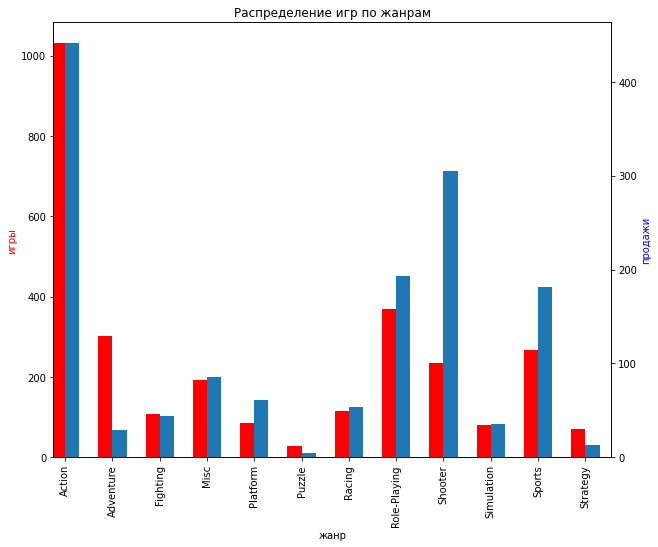

In [44]:
fig = plt.figure(figsize=(10,8))
ax_games = fig.add_subplot()
ax_sales = ax_games.twinx()
games.plot(kind='bar', ax=ax_games, position=1, color='red', width=0.3)
sales.plot(kind='bar', ax=ax_sales, position=0, width=0.3)
ax_games.legend().set_visible(False)
ax_sales.legend().set_visible(False)
ax_games.set_ylabel('игры', color='red')
ax_sales.set_ylabel('продажи', color='blue')
ax_games.set_xlabel('жанр')
plt.title('Распределение игр по жанрам');

**Самым популярным жанром является Action, игр этого жанра более 1000, также он выступает лидером по количеству продаж, их более 400 миллионов, самым непопулярным жанром является Puzzle, также у этого жанра меньше всего продаж. Самым успешным жанром можно назвать Shooter, у него, при относительно небольшом количестве игр(около 250), высокое число продаж(чуть более 300 миллионов), а с играми жанра Adventure иначе, таких игр около 300, но продаж мало, около 30 миллионов.** 

**С 1994 года начало стремительно увеличиваться количество выпускаемых с каждым годом игр, так, если в 1994 году была выпущено 121 игра, то в 2008 году вышло чуть более 1400 игр, но после 2009 года количество игр начало снижаться, и в 2016 году было выпущено почти в три раза меньше игр, чем в 2008 или 2009 году.**

**Для исследования был взят период за последние пять лет(2012-2016). За этот период в пятурку лидеров платформ по числу продаж вошли PS4, PS3, X360, 3DS, XOne. У всех платформ снизилось количество продаж в 2016 году, по сравнению с 2015 годом, лишь все платформы росли до 2015 года: PS4 и XOne, они могут показать результаты лучше, чем в 2016 году.** 

**Исходя из исследования, продажи платформ зависят от оценки критиков, но не сильно, исключением является платформа PSV,там зависимость практически не прослеживается. Оценки пользователей почти никак не влияют на продажи, лишь у платформ WiiU и 3DS есть небольшая зависимость.**

**Самым популярным жанром игр является Action, также он и явлется лидером по продажам, саммы непопулярным жанром выступает Puzzle, здесь также меньше всего продаж. Часто бывает, что жанры с небольшим количеством игр имеют высокие продажи, например, Shooter, или наоборот, игры с большим количеством игр имеют низкие продажи, например, Adventure.**

### Составление портрета пользователя каждого региона

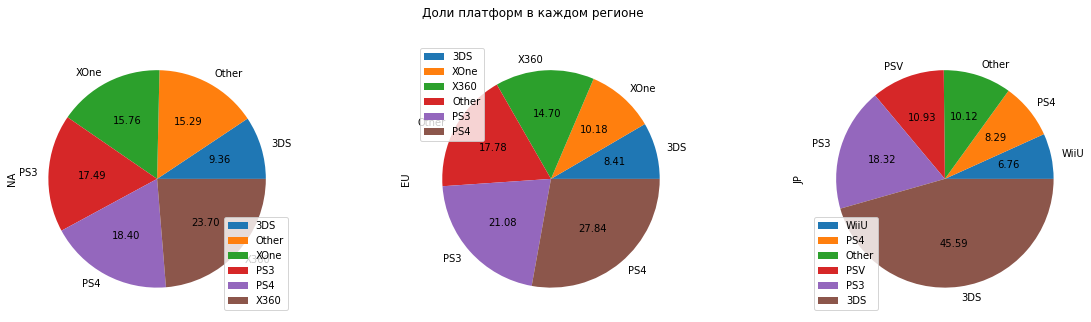

In [45]:
top5 = data_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales').tail()
data_copy = data_actual.copy()
data_copy.loc[~data_copy['platform'].isin(top5.index), 'platform'] = 'Other'
top5_na_platforms = data_copy.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales')

top5_eu = data_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales').tail()
data_copy2 = data_actual.copy()
data_copy2.loc[~data_copy2['platform'].isin(top5_eu.index), 'platform'] = 'Other'
top5_eu_platforms = data_copy2.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales')

top5_jp = data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales').tail()
data_copy3 = data_actual.copy()
data_copy3.loc[~data_copy3['platform'].isin(top5_jp.index), 'platform'] = 'Other'
top5_jp_platforms = data_copy3.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales')

plt.subplots(figsize=(20,5))
top5_na_platforms.plot(kind='pie', subplots=True, autopct='%.2f', ax = plt.subplot(1,3,1), ylabel='NA', title='Доли платформ в каждом регионе');
top5_eu_platforms.plot(kind='pie', subplots=True, autopct='%.2f', ax = plt.subplot(1,3,2), ylabel='EU');
top5_jp_platforms.plot(kind='pie', subplots=True, autopct='%.2f', ax = plt.subplot(1,3,3), ylabel='JP');


**В NA регионе в топ-5 платформ по продажам входят X360, PS4, PS3, XOne, 3DS, лидирующую позицию занимает X360, доля продаж у этой платформы занимает 23.7%.**
**В EU регионе в топ-5 входят те же платформы, что и в NA, но самая большая доля продаж у PS4(27.84%), а не у X360, здесь эта платформа лишь на третьем месте c долей 14.7%, пятерку лидеров, также, как и в NA закрывает 3DS.**
**В JP региона ситуация иная, на платформу 3DS приходится почти половина продаж(45.59%), в топ-5 также попали PS4, PS3, PSV, WiiU.**

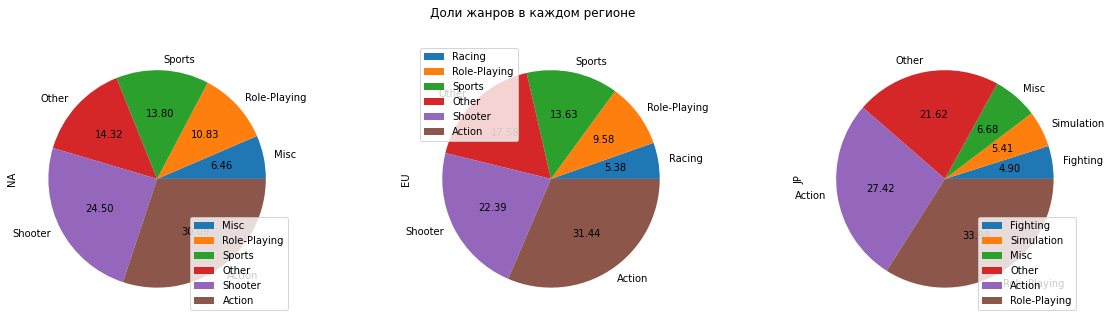

In [46]:
top5_g_na = data_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales').tail()
data_copy4 = data_actual.copy()
data_copy4.loc[~data_copy4['genre'].isin(top5_g_na.index), 'genre'] = 'Other'
top5_na_genres = data_copy4.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales')

top5_g_eu = data_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales').tail()
data_copy5 = data_actual.copy()
data_copy5.loc[~data_copy5['genre'].isin(top5_g_eu.index), 'genre'] = 'Other'
top5_eu_genres = data_copy5.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales')

top5_g_jp = data_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales').tail()
data_copy6 = data_actual.copy()
data_copy6.loc[~data_copy6['genre'].isin(top5_g_jp.index), 'genre'] = 'Other'
top5_jp_genres = data_copy6.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales')

plt.subplots(figsize=(20,5))
top5_na_genres.plot(kind='pie', subplots=True, autopct='%.2f', ax = plt.subplot(1,3,1), ylabel='NA', title='Доли жанров в каждом регионе');
top5_eu_genres.plot(kind='pie', subplots=True, autopct='%.2f', ax = plt.subplot(1,3,2), ylabel='EU');
top5_jp_genres.plot(kind='pie', subplots=True, autopct='%.2f', ax = plt.subplot(1,3,3), ylabel='JP');


**В топ-5 популярных жанров в NA регионе вошли Action, Shooter, Sports, Role-Playying и Misc.**
**В EU регионе топ-4 совпадает с NA, но топ-5 закрывает жанр Racing, а не Misc. Каждый жанр занимает практически одинаковые доли в обоих регионах.**
**В JP регионе лидирует жанр Role-Playying, который занимает треть продаж, также в пятерку лидеров вошли такие жанры, как Action, Misc, Simulation, Fighting.**

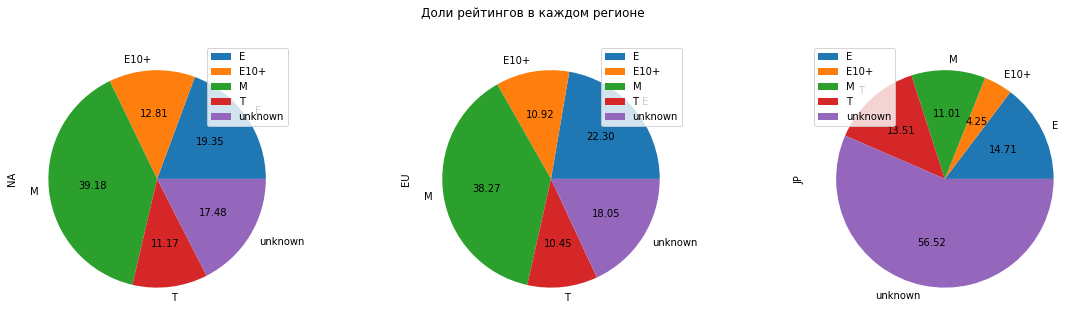

In [47]:
plt.subplots(figsize=(20,5))
data_actual.pivot_table(index='rating', values='na_sales', aggfunc='sum').plot(kind='pie', subplots=True, autopct='%.2f', ax = plt.subplot(1,3,1), ylabel='NA', title='Доли рейтингов в каждом регионе')
data_actual.pivot_table(index='rating', values='eu_sales', aggfunc='sum').plot(kind='pie', subplots=True, autopct='%.2f', ax = plt.subplot(1,3,2), ylabel='EU')
data_actual.pivot_table(index='rating', values='jp_sales', aggfunc='sum').plot(kind='pie', subplots=True, autopct='%.2f', ax = plt.subplot(1,3,3), ylabel='JP');

**В NA и EU регионах игр в рейтингом "M" продается больше всего, почти 40 процентов в каждом из регионов, на втором месте идут игры с рейтингом "E", на третьем и четверотом месте игры с рейтингами "E10+" и "T". В JP регионе больше всего игр с рейтингом "E", далее идут "T", "M", "E10+". Но в каждом регионе много продаж занимают игр, в которых рейтинг не известен, в JP регионе доля составляет почти 57%. Скорее всего это из-за того, что в этом регионе в топе по продажам находятся платформы и игры, которые намного менее популярны в NA и EU, возможно этим играм не присвоен рейтинг или же для многих этих игр рейтинг пропущен.**

In [48]:
data_actual.pivot_table(index='name', values='jp_sales').sort_values(by='jp_sales').tail(20)

,jp_sales
name,
Dragon Quest VII: Warriors of Eden,1.30
Yokai Watch 3,1.33
Yokai Watch,1.33
Animal Crossing: Happy Home Designer,1.40
Splatoon,1.46
Puzzle & Dragons,1.51
Super Smash Bros. for Wii U and 3DS,1.62
Tomodachi Life,1.90
Pokemon Sun/Moon,2.26


In [49]:
data_actual.query('name=="Pokemon X/Pokemon Y"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.6


In [50]:
data_actual.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
62,New Super Mario Bros. 2,3DS,2012,Platform,3.66,3.14,2.47,0.63,78.0,7.2,E,9.90


### Проверка гипотез

**Гипотеза 1:**   
H_0: средняя пользовательская оценка платформы Xbox One = средняя пользовательская оценка платформы PC    
H_1: средняя пользовательская оценка платформы Xbox One ≠ средняя пользовательская оценка платформы PC

In [51]:
xone_score = list(data_actual.loc[(data_actual['platform']=='XOne')&(~data_actual['user_score'].isna()), 'user_score'])
pc_score = list(data_actual.loc[(data_actual['platform']=='PC')&(~data_actual['user_score'].isna()), 'user_score'])

In [52]:
alpha = .05
results = st.ttest_ind(xone_score, pc_score, equal_var = False)
print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value:  0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


**Значение p-value получилось большим, нельзя сказать, что оценки пользователей, зависят от платформы.**

**Гипотеза 2:**   
H_0: средняя пользовательская оценка платформы жанра Action = средняя пользовательская оценка платформы жанра Sports    
H_1: средняя пользовательская оценка платформы жанра Action ≠ средняя пользовательская оценка платформы жанра Sports 

In [53]:
action_score = list(data_actual.loc[(data_actual['genre']=='Action')&(~data_actual['user_score'].isna()), 'user_score'])
sports_score = list(data_actual.loc[(data_actual['genre']=='Sports')&(~data_actual['user_score'].isna()), 'user_score'])

In [54]:
results_genre = st.ttest_ind(action_score, sports_score, equal_var = False)
print('p-value: ', results_genre.pvalue)
if results_genre.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value:  4.24307776572644e-20
Отвергаем нулевую гипотезу


**Нулевая гипотеза отвергнута, значит оценка пользователей зависит от жанра игры.**

### Общий вывод

**В исходных данных были обнаружены пропущенные значения, были удалены строки с пропущенными названиями и годами релизов игр, часть пропусков была заполнена, но от некоторых пропусков избавиться не удалось, т.к. их заполнение может некорректно сказаться за итоговых результатах, также были изменены названия столбцов в соответствии с «хорошим стилем».**

**В ходе исследования выяснилось, что в период 1980-1993 года выпускалось менее 100 игр в год и начиная с 1994 года число выпускаем игр начало увеличиваться вплоть до 2009 года, далее количество выпускаемых в год игр начало сокращаться. Был определен актуальный период: 2012-2016 год, в дальнейшем исследовании использовались данные только за этот срок.**

**В пятерку лидирующих по продажам платформам вошли PS4, PS3, X360, 3DS, XOne. Все платформы в 2016 году сделали меньше продаж, по сравнению с 2015 годом, многие платформы начали падать еще до этого, исключением являются PS4 и XOne, они росли вплоть до 2015 года. Эти платформы в 2017 потенциально могут показать результаты лучше, чем в 2016.**

**Была выявлена небольшая зависимость между продажами и оценками критиков, исключением является платформа PSV, тут зависимости практически не наблюдается. Также нет зависимости между оценками пользователей и продажами, но и здесь есть исключения, у платформ WiiU и 3DS прослеживается небольшая зависимость.**

**Самым популярным жанром игр серди всех платформ оказался жанр Action, наименее популярные Puzzle-игры. Самым успешным жанром можно назвать Shooter, у него, при относительно небольшом количестве игр, высокое число продаж, а с играми жанра Adventure иначе, при большом количестве таких игр продаж относительно мало.**

**В NA и EU регионах в топ-5 платформ вошли PS4, PS3, XOne, X360, 3DS, разница только в лидерах: в NA это X360, а в EU это PS4. У JP региона картина сильно отличается, так почти половину от продаж занимает платформа 3DS, еще в топ-5 вошли PS4, PS3, PSV, WiiU.**

**Жанры Action, Shooter, Sports, Role-Playying в NA и EU регионах занимают практически одинаковые доли от продаж, но на пятом месте жанры разные: в NA это Misc, в EU это Racing. В JP, как и в случае с платформами, картина разница с остальными регионами. В топ-5 жанров здесь входят Role-Playing, Action, Misc, Simulation, Fighting.**

**Игры с одним рейтингом ESRB в регионах NA и EU занимают практически одинаковые доли, в JP регионе абсолютное большинство продаж занимают игры без рейтинга, скорее всего здесь более популярны игры, которым рейтинг не присвоен или у которых пропущен.**

**В ходе проверок гипотез выяснилось, что оценки пользователей не зависят от платформы XOne или PC, а вот оценки у жанров Sports и Action разнятся.**